# Purpose
Remove the highly correlated columns and to the regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
import time 

#to keep things in order, and to avoid to copy and paste everytime our functions if we want to use them in more than one folder,
#we can temporarily use this library. 
import sys

#in this way Python will search the implementations also in the path '../HelperFunctions'
sys.path.insert(0, '../HelperFunctions')
sys.path.insert(0, '../pre-processing/Clean_Data/')

from proj1_helpers import *
from common_functions import *
from counters import *
from remove import *
from replace import *
from regressors import *
from CrossValidationFunctions import *

In [2]:
yb, input_data, ids = load_csv_data("../data/train.csv", sub_sample=False)
_, test_data, ids_test = load_csv_data("../data/test.csv", sub_sample=False)

#this will surely be deleted, in this way we are sure that original_data is the original version of the data and we don't have
#to load them again
from copy import deepcopy
originalData = deepcopy(input_data)
originalY = deepcopy(yb)
originalTest = deepcopy(test_data)


# Preprocessing: removing the highly correlated columns

In [3]:
#Let's put 0 in the -999 generated by the "no sense" variable
input_data = deepcopy(originalData)
numInvalidValues=countInvalid(input_data, -999)
idxCols = np.where(numInvalidValues>0)[0]
input_data = replaceWithZero(input_data,-999,idxCols)

input_data, mean_train, std_train = standardize(input_data)

lowerBound = 0.85

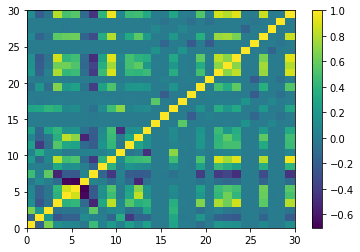

In [4]:
#Let's remove strongly correlated columns
import pylab

R = np.corrcoef(input_data.T)
pylab.pcolor(R)
pylab.colorbar()
pylab.show()


In [5]:
idx_high_correlation = np.where( (lowerBound < R) & (R < 0.99))
highCorrelatedCouples = list( zip(idx_high_correlation[0], idx_high_correlation[1]) )
print( highCorrelatedCouples)

[(3, 23), (4, 5), (5, 4), (9, 21), (9, 23), (9, 29), (21, 9), (21, 29), (23, 3), (23, 9), (23, 29), (26, 29), (29, 9), (29, 21), (29, 23), (29, 26)]


In [6]:
input_data = np.delete(input_data,23,axis=1)
R = np.corrcoef(input_data.T)
idx_high_correlation = np.where( (lowerBound < R) & (R < 0.99))
highCorrelatedCouples = list( zip(idx_high_correlation[0], idx_high_correlation[1]) )
print( highCorrelatedCouples)

[(4, 5), (5, 4), (9, 21), (9, 28), (21, 9), (21, 28), (25, 28), (28, 9), (28, 21), (28, 25)]


In [7]:
input_data = np.delete(input_data,28,axis=1)
R = np.corrcoef(input_data.T)
idx_high_correlation = np.where( (lowerBound < R) & (R < 0.99))
highCorrelatedCouples = list( zip(idx_high_correlation[0], idx_high_correlation[1]) )
print( highCorrelatedCouples)

[(4, 5), (5, 4), (9, 21), (21, 9)]


In [8]:
input_data = np.delete(input_data,21,axis=1)
R = np.corrcoef(input_data.T)
idx_high_correlation = np.where( (lowerBound < R) & (R < 0.99))
highCorrelatedCouples = list( zip(idx_high_correlation[0], idx_high_correlation[1]) )
print( highCorrelatedCouples)

[(4, 5), (5, 4)]


In [9]:
input_data = np.delete(input_data,5,axis=1)
R = np.corrcoef(input_data.T)
idx_high_correlation = np.where( (lowerBound < R) & (R < 0.99))
highCorrelatedCouples = list( zip(idx_high_correlation[0], idx_high_correlation[1]) )
print( highCorrelatedCouples)

[]


In [10]:
idx_removed = [23,28,21,5] #the order matters!!

# Regression


In [11]:
from CrossValidationFunctions import *
def grid_search_hyperparam_with_CV(y, tx, lambdas, degrees):
    loss_tr = np.zeros((len(lambdas), len(degrees)))
    loss_te = np.zeros((len(lambdas), len(degrees)))
    accuracy = np.zeros((len(lambdas), len(degrees)))
    
    for idx_lambda, lambda_ in enumerate(lambdas):
        for idx_degree, degree in enumerate(degrees):
                        
            x_augmented = build_poly(tx, degree)
            
            #regression with your favourite method
            k_indices = build_k_indices(y, 4, 1)
            acc, loss1, loss2 = cross_validation_with_ridge(y, x_augmented, k_indices, lambda_)
            
            loss_tr[idx_lambda, idx_degree] = loss1
            loss_te[idx_lambda, idx_degree] = loss2
            accuracy[idx_lambda, idx_degree] = acc
    
    #find the best using the loss
    min_loss_te = np.min(loss_te)
    best_lambda_loss = lambdas[ np.where( loss_te == min_loss_te )[0] ]
    best_degree_loss = degrees[ np.where( loss_te == min_loss_te )[1] ]

    #recompute best w
    x_augmented = build_poly(tx, int(best_degree_loss))
    best_w_loss = ridge_regression(y,x_augmented,best_lambda_loss)
    
    #find the best using the accuracy
    max_acc = np.max(accuracy)
    best_lambda_acc = lambdas[ np.where( accuracy == max_acc )[0] ]
    best_degree_acc = degrees[ np.where( accuracy == max_acc )[1] ]
    
    #recompute best w
    x_augmented = build_poly(tx, int(best_degree_acc[0]))
    best_w_acc = ridge_regression(y,x_augmented,best_lambda_acc[0])

    return best_lambda_loss, best_degree_loss, best_w_loss, best_lambda_acc, best_degree_acc, best_w_acc, loss_tr, loss_te, accuracy

In [12]:
lambdas = np.logspace(-6,0,10)
degrees = np.arange(3)
best_lambda_loss, best_degree_loss, best_w_loss, best_lambda_acc, best_degree_acc, best_w_acc, loss_tr, loss_te, accuracy = grid_search_hyperparam_with_CV(yb,input_data,lambdas,degrees)

In [13]:
print(f'lambda = {best_lambda_loss}, degree = {best_degree_loss}, loss = {np.min(loss_te)}')

print(f'\n\naccording to accuracy...')
print(f'lambda = {best_lambda_acc}, degree = {best_degree_acc}, loss = {np.max(accuracy)}')

lambda = [0.0001], degree = [1], loss = 0.8259131179004076


according to accuracy...
lambda = [0.00046416], degree = [2], loss = 0.7721959999999999


# Submission
<b> NOTE </b> that we can use idx_removed in a simple for loop to delete columns in the same order

In [14]:
Tdata = deepcopy(originalTest)

numInvalidValues=countInvalid(input_data, -999)
idxCols = np.where(numInvalidValues>0)[0]
input_data = replaceWithZero(input_data,-999,idxCols)

Tdata,_,_ = standardizeWithGivenParameters(test_data,mean_train,std_train)

#remove idxs in the same order
for idx in idx_removed:
    Tdata = np.delete(Tdata,idx,axis=1)
    
Test_augmented = build_poly(Tdata, int(best_degree_acc))
                            
y_pred = predict_labels(best_w_acc, Test_augmented)
create_csv_submission(ids_test, y_pred, '999to0andRemoveHiglyCorr.csv')